### Домашнее задание - Латентное пространство в VAE автоенкодере

Лучше всего читать оригинальные работы - обычно они очень хорошо и подробно написаны.  
Рекомендую прочитать оригинальную статью [Variational AutoEncoder](https://arxiv.org/pdf/1312.6114.pdf) (VAE, D.P. Kingma et. al., 2013)

В данном задании необходимо:

1. Реализовать обычный автоенкодер и VAE автоенкодер с архитектурой как на рисунке:
<img src='images/mnist_vae.png' width=300>

2. Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство, получить рисунок похожий на рисунок ниже для обоих автоенкодеров и сравнить результаты:
<img src='images/vae_mnist_cloud.png' width=300>

3. Построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='images/vae_mnist_digits.png' width=300>

4. (*) Скачать датасет со знаменитостями [celebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) и повторить для него, предварительно (если нужно) сократив размеры картинок, чтобы ускорить работу. Поэкспериментировать с модификацией изображений лиц - например, добавляя очки или изменяя цвет волос.
<img src='images/celeA_intro.png' width=300>

**Замечание** Для того, чтобы реализовать VAE, прочитайте данную ниже небольшаую теоретическую справку и выполните задание в конце.

### Кроссэнтропия
В теории информации перекрёстная энтропия (или *кроссэнтропия*) между двумя распределениями вероятностей измеряет среднее число бит, необходимых для опознания события из набора возможностей, если используемая схема кодирования базируется на заданном распределении вероятностей $q$, вместо «истинного» распределения $p$.  
Кроссэнтропией распределения $q$ по отношению к распределению $p$ называется величина:  
$$H(p, q) \stackrel{\mathrm{df}}{\;=\;} \mathrm{E}_p[-\log q] = -\sum_x p(x)\, \log q(x) = H(p) + D_{KL}(p \| q),$$  
<!-- или  $$H(p, q) = -\int\limits_X p(x)\, \log q(x)\, dx.$$ -->
где $H(p)$ - энтропия распределения $p$, $D_{KL}(p \| q)$ - дивергенция Кульбака-Лейблера. Можно показать, что энтропия $H(p)$ всегда меньше чем кроссэнтропия $H(p, q)$. Таким образом, дивергенция Кульбака-Лейблера - неотрицательная величина.



### Дивергенция Кульбака-Лейблера
Расхождение (дивергенция) Ку́льбака-Ле́йблера (англ. Kullback–Leibler divergence), РКЛ, — информационное расхождение, различающая информация, информационный выигрыш, относительная энтропия (англ. relative entropy). Это неотрицательнозначный функционал, являющийся несимметричной мерой удалённости друг от друга двух вероятностных распределений $p$ и $q$, определённых на общем пространстве элементарных событий:  
$$D_{\mathrm{KL}}(p\parallel q) = \sum_x p(x) \, \log \frac{p(x)}{q(x)} \,$$

### Дивергенция Кульбака-Лейблера для многомерного нормального распределения
Допустим, что мы имеем два многомерных нормальных распределения, со средними $\mu_0, \mu_1$ и с (обратимыми) матрицами ковариаций $\Sigma_0, \Sigma_1$. Если два распределения имеют одинаковую размерность $k$, то РКЛ между распределениями следующее:  
$$D_\text{KL}(\mathcal{N}_0 \parallel  \mathcal{N}_1) = { 1 \over 2 } \left( \mathrm{tr} \left( \Sigma_1^{-1} \Sigma_0 \right) + \left( \mu_1 - \mu_0\right)^\top \Sigma_1^{-1} ( \mu_1 - \mu_0 ) - k + \ln \left( { \det \Sigma_1 \over \det \Sigma_0  } \right)  \right).$$


Упростите данное выражение для случая, которое используется в VAE, когда компоненты векторов независимы, т.е. матрицы ковариации диагональны. Также упростите выражение, когда второе распределение $\mathcal{N}_1$ является стандартным, т.е. с нулевыми средними и единичными дисперсиями.

### Загрузка данных MNIST

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
INPUT_SIZE = 784
BATCH_SIZE = 100

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1000, 
                                          shuffle=False)


## MNIST автоенкодер

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size, latent_size)
                                  )
    def forward(self, X):
        return self.model(X)

class Decoder(nn.Module):
    def __init__(self,  input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.model = nn.Sequential(nn.Linear(latent_size, hidden_size),
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size, input_size)
                                  )
    def forward(self, X):
        return self.model(X)
    
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size, latent_size, hidden_size)
        self.decoder = Decoder(input_size, latent_size, hidden_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent)


In [7]:
model1 = Autoencoder(input_size=INPUT_SIZE, latent_size=2)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)  

# Train the model
num_epochs = 20
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images
        #labels = labels.to(device)
        
        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/20], Step [100/600], Loss: 0.0570
Epoch [1/20], Step [200/600], Loss: 0.0520
Epoch [1/20], Step [300/600], Loss: 0.0508
Epoch [1/20], Step [400/600], Loss: 0.0524
Epoch [1/20], Step [500/600], Loss: 0.0489
Epoch [1/20], Step [600/600], Loss: 0.0504
Epoch [2/20], Step [100/600], Loss: 0.0513
Epoch [2/20], Step [200/600], Loss: 0.0469
Epoch [2/20], Step [300/600], Loss: 0.0450
Epoch [2/20], Step [400/600], Loss: 0.0475
Epoch [2/20], Step [500/600], Loss: 0.0471
Epoch [2/20], Step [600/600], Loss: 0.0428
Epoch [3/20], Step [100/600], Loss: 0.0451
Epoch [3/20], Step [200/600], Loss: 0.0441
Epoch [3/20], Step [300/600], Loss: 0.0474
Epoch [3/20], Step [400/600], Loss: 0.0470
Epoch [3/20], Step [500/600], Loss: 0.0432
Epoch [3/20], Step [600/600], Loss: 0.0446
Epoch [4/20], Step [100/600], Loss: 0.0450
Epoch [4/20], Step [200/600], Loss: 0.0456
Epoch [4/20], Step [300/600], Loss: 0.0457
Epoch [4/20], Step [400/600], Loss: 0.0465
Epoch [4/20], Step [500/600], Loss: 0.0404
Epoch [4/20

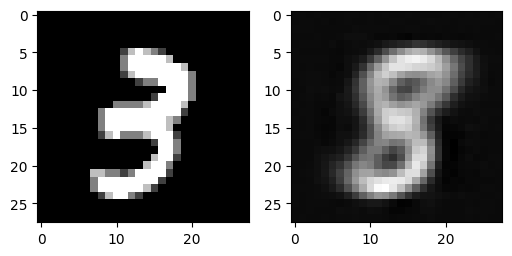

tensor(3)


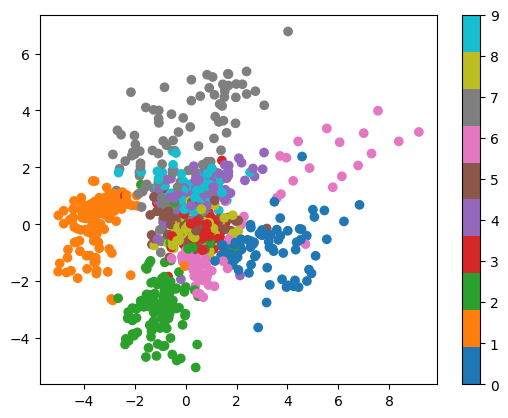

In [8]:
from matplotlib import pyplot as plt

for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output = model1(images)

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

# fig, axs = plt.subplots(1, 2)#, figsize=(12, 6))
# axs[0].hist(orig_img.flatten(), bins=25)
# axs[1].hist(img.flatten(), bins=25)
# plt.show()

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
latent = model1.encoder(images)
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

## Регуляризация автоенкодера

In [9]:
class Autoencoder_latent(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size, latent_size, hidden_size)
        self.decoder = Decoder(input_size, latent_size, hidden_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent), latent

In [10]:
model2 = Autoencoder_latent(input_size=INPUT_SIZE, latent_size=2)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  
LAMBDA = 0.1
# Train the model
num_epochs = 20
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images
        #labels = labels.to(device)
        
        # Forward pass
        outputs, latent = model2(images)
        reconstruction_loss = criterion(outputs, labels)
        regulizer_loss = (latent * latent).sum(axis=1).mean()
        
        loss = reconstruction_loss + LAMBDA/2 * regulizer_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], reconstruction_loss:{:.6f}, regulizer_loss:{:.6f}, Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, 
                           reconstruction_loss.item(), regulizer_loss.item(), loss.item()))


Epoch [1/20], Step [100/600], reconstruction_loss:0.065105, regulizer_loss:0.027525, Loss: 0.0665
Epoch [1/20], Step [200/600], reconstruction_loss:0.057398, regulizer_loss:0.025578, Loss: 0.0587
Epoch [1/20], Step [300/600], reconstruction_loss:0.058861, regulizer_loss:0.014952, Loss: 0.0596
Epoch [1/20], Step [400/600], reconstruction_loss:0.057449, regulizer_loss:0.015133, Loss: 0.0582
Epoch [1/20], Step [500/600], reconstruction_loss:0.055281, regulizer_loss:0.013610, Loss: 0.0560
Epoch [1/20], Step [600/600], reconstruction_loss:0.057225, regulizer_loss:0.014313, Loss: 0.0579
Epoch [2/20], Step [100/600], reconstruction_loss:0.052895, regulizer_loss:0.012280, Loss: 0.0535
Epoch [2/20], Step [200/600], reconstruction_loss:0.052938, regulizer_loss:0.014191, Loss: 0.0536
Epoch [2/20], Step [300/600], reconstruction_loss:0.053464, regulizer_loss:0.012429, Loss: 0.0541
Epoch [2/20], Step [400/600], reconstruction_loss:0.052825, regulizer_loss:0.015132, Loss: 0.0536
Epoch [2/20], Step [

Epoch [15/20], Step [100/600], reconstruction_loss:0.045730, regulizer_loss:0.014110, Loss: 0.0464
Epoch [15/20], Step [200/600], reconstruction_loss:0.042306, regulizer_loss:0.015735, Loss: 0.0431
Epoch [15/20], Step [300/600], reconstruction_loss:0.046322, regulizer_loss:0.012349, Loss: 0.0469
Epoch [15/20], Step [400/600], reconstruction_loss:0.044730, regulizer_loss:0.014059, Loss: 0.0454
Epoch [15/20], Step [500/600], reconstruction_loss:0.045060, regulizer_loss:0.011741, Loss: 0.0456
Epoch [15/20], Step [600/600], reconstruction_loss:0.048070, regulizer_loss:0.010523, Loss: 0.0486
Epoch [16/20], Step [100/600], reconstruction_loss:0.048519, regulizer_loss:0.011090, Loss: 0.0491
Epoch [16/20], Step [200/600], reconstruction_loss:0.050682, regulizer_loss:0.013380, Loss: 0.0514
Epoch [16/20], Step [300/600], reconstruction_loss:0.041833, regulizer_loss:0.013497, Loss: 0.0425
Epoch [16/20], Step [400/600], reconstruction_loss:0.044911, regulizer_loss:0.014026, Loss: 0.0456
Epoch [16/

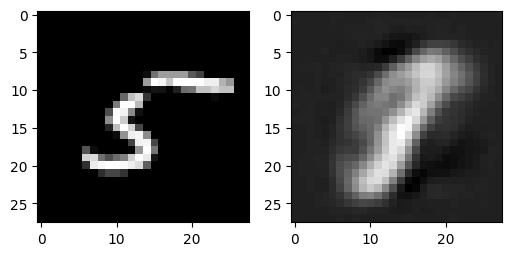

tensor(5)


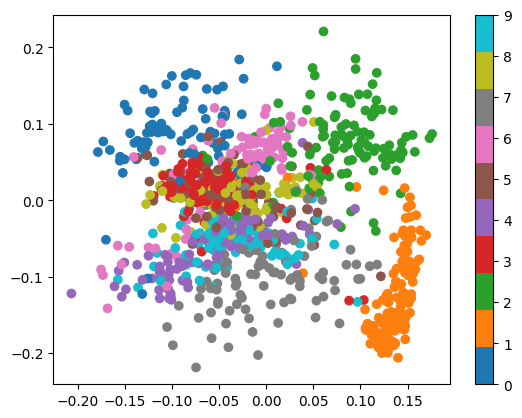

In [11]:
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, latent = model2(images)

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, latent = model2(images)
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

In [12]:
import numpy as np
lim = 0.15
xx = np.linspace(-lim, lim, 15)
yy = np.linspace(-lim, lim, 15)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.size, 2)) #np.concatenate((XX[None], YY[None]), axis=0)
ZZ[:,0] = XX.flatten()
ZZ[:,1] = YY.flatten()

latent_gen = torch.FloatTensor(ZZ).to(device)
output = model2.decoder(latent_gen)

In [13]:
images = output.detach().numpy()
big_image = np.zeros((15 * 28, 15 * 28))
for i in range(15):
    for j in range(15):
        big_image[i*28 : (i+1)*28, j*28 : (j+1)*28] = 1 - images[15*i + j].reshape(28, 28)

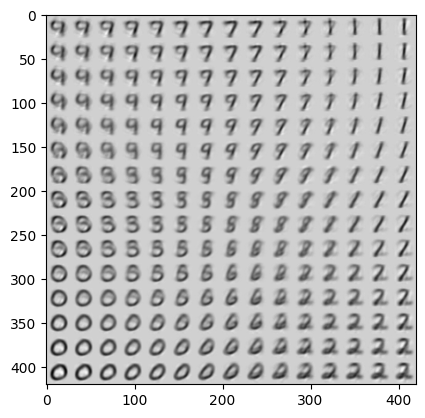

In [14]:
plt.imshow(big_image, cmap='gray')
plt.show()

## VAE автоенкодер

# Точнее его попытки

In [15]:
class VAE_Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        # encoder
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_size), 
                                   nn.ReLU())
        self.mu = nn.Linear(self.hidden_size, self.latent_size)
        self.sigma = nn.Linear(self.hidden_size, self.latent_size)
        # decoder
        self.decoder = nn.Sequential(nn.Linear(self.latent_size, self.hidden_size), nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.input_size), nn.Sigmoid())
        
    def encode(self, x):
        encoded_hidden = self.encoder(x)
        mu, sigma = self.mu(encoded_hidden), self.sigma(encoded_hidden)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, X):
        mu, sigma = self.encode(X)
        epsilon = torch.rand_like(sigma)
        z_reparametrized = mu + sigma * epsilon
        x_reconstructed = self.decode(z_reparametrized)

        return x_reconstructed, z_reparametrized, mu, sigma

In [16]:
model3 = VAE_Autoencoder(input_size=INPUT_SIZE, latent_size=2)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)  

# Train the model
num_epochs = 20
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images
        #labels = labels.to(device)
        
        # Forward pass
        outputs, _, mu, sigma = model3(images)
        KLD = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = criterion(outputs, labels) + 3 * KLD
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/20], Step [100/600], Loss: 60.7809
Epoch [1/20], Step [200/600], Loss: 42.6928
Epoch [1/20], Step [300/600], Loss: 31.6841
Epoch [1/20], Step [400/600], Loss: 23.6641
Epoch [1/20], Step [500/600], Loss: 21.3473
Epoch [1/20], Step [600/600], Loss: 6.9870
Epoch [2/20], Step [100/600], Loss: 3.5254
Epoch [2/20], Step [200/600], Loss: 2.7941
Epoch [2/20], Step [300/600], Loss: 1.7531
Epoch [2/20], Step [400/600], Loss: 1.1779
Epoch [2/20], Step [500/600], Loss: 0.7582
Epoch [2/20], Step [600/600], Loss: 0.6123
Epoch [3/20], Step [100/600], Loss: 0.4357
Epoch [3/20], Step [200/600], Loss: 0.4654
Epoch [3/20], Step [300/600], Loss: 0.4040
Epoch [3/20], Step [400/600], Loss: 0.2993
Epoch [3/20], Step [500/600], Loss: 0.2882
Epoch [3/20], Step [600/600], Loss: 0.1821
Epoch [4/20], Step [100/600], Loss: 0.1708
Epoch [4/20], Step [200/600], Loss: 0.1825
Epoch [4/20], Step [300/600], Loss: 0.1451
Epoch [4/20], Step [400/600], Loss: 0.1771
Epoch [4/20], Step [500/600], Loss: 0.1405
Epoch 

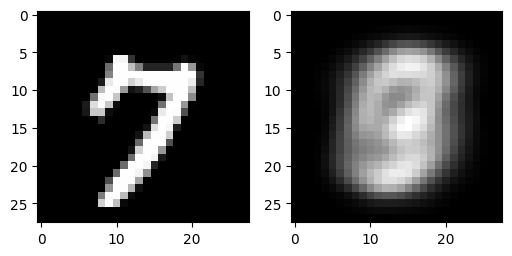

tensor(7)


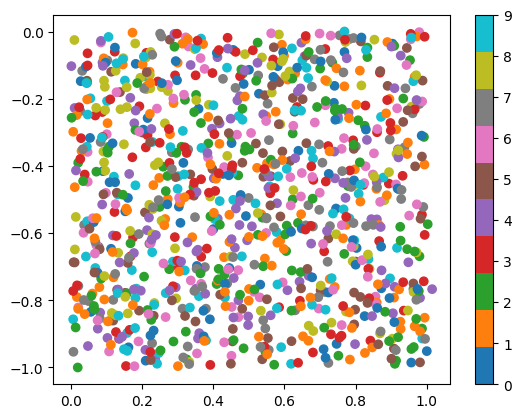

In [17]:
from matplotlib import pyplot as plt

for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, _, _, _ = model3(images)

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

# fig, axs = plt.subplots(1, 2)#, figsize=(12, 6))
# axs[0].hist(orig_img.flatten(), bins=25)
# axs[1].hist(img.flatten(), bins=25)
# plt.show()

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
_, latent, _, _ = model3.forward(images)
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

In [18]:
import numpy as np
lim = 0.15
xx = np.linspace(-lim, lim, 15)
yy = np.linspace(-lim, lim, 15)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.size, 2)) #np.concatenate((XX[None], YY[None]), axis=0)
ZZ[:,0] = XX.flatten()
ZZ[:,1] = YY.flatten()

latent_gen = torch.FloatTensor(ZZ).to(device)
output = model3.decoder(latent_gen)

In [19]:
images = output.detach().numpy()
big_image = np.zeros((15 * 28, 15 * 28))
for i in range(15):
    for j in range(15):
        big_image[i*28 : (i+1)*28, j*28 : (j+1)*28] = 1 - images[15*i + j].reshape(28, 28)

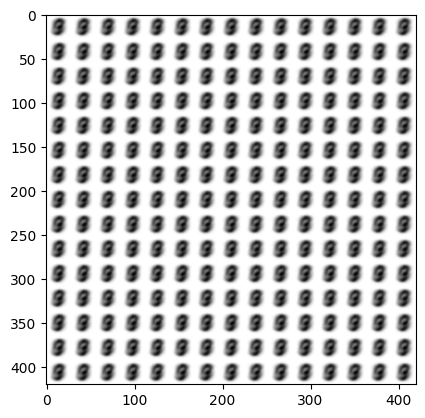

In [20]:
plt.imshow(big_image, cmap='gray')
plt.show()

## CelebA

In [114]:
from PIL import Image

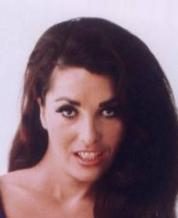

In [120]:
import os
foldername = 'img_celebA_part'
list_images = os.listdir(foldername)
#for i in os.listdir(foldername)
img = Image.open(os.path.join(foldername, list_images[10]))
img

In [122]:
image = np.array(img)
image.shape

(218, 178, 3)

In [123]:
from torchvision import transforms

In [124]:
crop_transform = transforms.CenterCrop((150, 150))

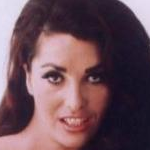

In [125]:
crop_transform(img)

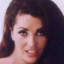

In [127]:
resize_transform = transforms.Resize((64, 64))
resize_transform(crop_transform(img))

In [138]:
from PIL import Image

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, folder_name, transforms=None):
        self.folder_name = folder_name
        self.images_list =  os.listdir(folder_name)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images_list)
        
    def __getitem__(self, idx):
        #file_name = self.folder_name + '/' + self.images_list[idx]
        file_name = os.path.join(self.folder_name, self.images_list[idx])
        img = Image.open(file_name)
        if self.transforms is not None:
            img = self.transforms(img)
        return img

transforms = transforms.Compose([
        transforms.CenterCrop((150, 150)),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

dataset = CelebADataset(folder_name='img_celebA_part', transforms=transforms)

In [140]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                           batch_size=1000, 
#                                           shuffle=False)